# Standard BNN Demo 


In [24]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Our modules
from datasets import get_mnist_dataloaders, infer_dataset_info
from models import create_mlp, StandardBNN
from utils import set_random_seeds

# Set random seeds 
set_random_seeds(123)

# GPU info (device selection handled by BNN)
if torch.cuda.is_available():
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("No GPU available - will use CPU")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


GPU Available: NVIDIA GeForce RTX 4090
Memory: 25.4 GB


## Load MNIST Dataset


In [26]:
# Load MNIST data
train_loader, val_loader, test_loader = get_mnist_dataloaders(
    data_dir="../data",
    batch_size=128,
    train_split=1,
    flatten=True,  # Flatten for MLP
    normalize=True
)

# Infer dataset information from the dataloader
dataset_info = infer_dataset_info(train_loader)
print("\nDataset Info:")
for key, value in dataset_info.items():
    print(f"  {key}: {value}")

print(f"\nDataloader Info:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Show a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
print(f"\nSample batch:")
print(f"  Images shape: {sample_images.shape}")
print(f"  Labels shape: {sample_labels.shape}")
print(f"  Images device: {sample_images.device}")
print(f"  Labels device: {sample_labels.device}")



Dataset Info:
  input_shape: (784,)
  input_size: 784
  num_classes: 10

Dataloader Info:
  Training batches: 469
  Validation batches: 0
  Test batches: 79

Sample batch:
  Images shape: torch.Size([128, 784])
  Labels shape: torch.Size([128])
  Images device: cpu
  Labels device: cpu


## Create and Train BNN Model


In [29]:
# Create MLP model
model = create_mlp(
    input_size=dataset_info['input_size'],  # 784 for flattened MNIST
    hidden_sizes=[256, 128],
    num_classes=dataset_info['num_classes'],  # 10 for MNIST
    dropout_rate=0
)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create Standard BNN 
bnn = StandardBNN(
    model=model,
    num_classes=dataset_info['num_classes'],
    prior_std=1.0,
    temperature=0.2,
    mcmc_method="sgld",  # Stochastic Gradient Langevin Dynamics
    device='auto'  # Auto-detect GPU/CPU
)

print(f"\nStandard BNN:")
print(f"  Method: {bnn.mcmc_method}")
print(f"  Prior std: {bnn.prior_std}")
print(f"  Temperature: {bnn.temperature}")
print(f"  Device: {bnn.device}")
print(f"  Model parameters on: {next(bnn.model.parameters()).device}")


Model Architecture:
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 235,146
Auto-detected GPU: NVIDIA GeForce RTX 4090
BNN initialized on device: cuda

Standard BNN:
  Method: sgld
  Prior std: 1.0
  Temperature: 0.2
  Device: cuda
  Model parameters on: cuda:0


In [30]:
# Train the BNN
bnn.fit(
    train_loader=train_loader,
    num_epochs=30,  # Reduced for demo
    lr=1e-3,
    num_burn_in=10,  # Shorter burn-in for demo
    verbose=True
)

Training BNN: 100%|██████████| 30/30 [01:52<00:00,  3.76s/it, Samples Collected=9380, Burn-in=Complete]

Training completed! Collected 9380 posterior samples.


## 3. Evaluate and Analyze Results


In [31]:
# Evaluate on test set
test_metrics = bnn.evaluate(test_loader)

In [34]:
print("\nTest Results:")
for metric, value in test_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")



Test Results:
  accuracy: 0.9079
  ece: 0.0639
  avg_uncertainty: 0.0041
  num_samples: 9380
  test_samples: 10000
  loss: 0.3363
  total_uncertainty: 0.4954
  aleatoric_uncertainty: 0.4834
  epistemic_uncertainty: 0.0120


In [35]:
# # Create comprehensive visualization
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# # 1. Uncertainty distribution
# axes[0, 0].hist(uncertainties.cpu().numpy(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
# axes[0, 0].set_xlabel('Epistemic Uncertainty')
# axes[0, 0].set_ylabel('Count')
# axes[0, 0].set_title('Overall Uncertainty Distribution')
# axes[0, 0].grid(True, alpha=0.3)

# # 2. Uncertainty by correctness
# if len(correct_uncertainties) > 0:
#     axes[0, 1].hist(correct_uncertainties.cpu().numpy(), bins=20, alpha=0.7, label='Correct', color='green')
# if len(incorrect_uncertainties) > 0:
#     axes[0, 1].hist(incorrect_uncertainties.cpu().numpy(), bins=20, alpha=0.7, label='Incorrect', color='red')
# axes[0, 1].set_xlabel('Epistemic Uncertainty')
# axes[0, 1].set_ylabel('Count')
# axes[0, 1].set_title('Uncertainty by Correctness')
# axes[0, 1].legend()
# axes[0, 1].grid(True, alpha=0.3)

# # 3. Confidence vs uncertainty scatter
# max_probs = torch.max(predictions, dim=1)[0]
# scatter = axes[0, 2].scatter(max_probs.cpu().numpy(), uncertainties.cpu().numpy(), 
#                            c=correct.cpu().numpy(), cmap='RdYlGn', alpha=0.6, s=50)
# axes[0, 2].set_xlabel('Max Probability (Confidence)')
# axes[0, 2].set_ylabel('Epistemic Uncertainty')
# axes[0, 2].set_title('Confidence vs Uncertainty')
# plt.colorbar(scatter, ax=axes[0, 2], label='Correct (1) / Incorrect (0)')
# axes[0, 2].grid(True, alpha=0.3)

# # 4-6. Example predictions with uncertainties
# images_viz = images.view(-1, 28, 28)  # Reshape for visualization
# for i, ax in enumerate(axes[1, :]):
#     if i < len(images_viz):
#         ax.imshow(images_viz[i], cmap='gray')
#         true_label = labels[i].item()
#         pred_label = pred_classes[i].item()
#         confidence = max_probs[i].item()
#         uncertainty = uncertainties[i].item()
        
#         color = 'green' if true_label == pred_label else 'red'
#         title = f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}, Unc: {uncertainty:.3f}'
#         ax.set_title(title, color=color, fontsize=10)
#         ax.axis('off')
#     else:
#         ax.axis('off')

# plt.suptitle('BNN Uncertainty Analysis', fontsize=16, y=0.98)
# plt.tight_layout()
# plt.show()

# # Print correlation analysis
# if len(uncertainties) > 1:
#     correlation = torch.corrcoef(torch.stack([uncertainties, 1-correct]))[0,1]
#     print(f"\n Correlation between uncertainty and errors: {correlation:.4f}")
#     if correlation > 0.1:
#         print("   Good! Higher uncertainty correlates with incorrect predictions")
#     else:
#         print("   Weak correlation between uncertainty and errors")


In [36]:
import torch
from utils import evaluation as eval_utils

# Assumes `bnn` (trained) and `test_loader` are already defined above
assert 'bnn' in globals(), "Expected a trained `bnn` in the notebook context."
assert 'test_loader' in globals(), "Expected `test_loader` in the notebook context."


In [37]:
# Use the BNN's device
device = bnn.device if hasattr(bnn, 'device') else ('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# Analyze predictions using all collected posterior samples
analysis = eval_utils.analyze_predictions(bnn, test_loader, num_samples=None, device=device)

preds = analysis['predictions']
uncs = analysis['uncertainties']
labels = analysis['labels']
correct = analysis['correct']

In [39]:
# Compute calibration metrics
calib = eval_utils.compute_calibration_metrics(preds, labels, n_bins=10)
print('Calibration metrics:')
for k, v in calib.items():
    print(f"  {k}: {v:.4f}")

Calibration metrics:
  ece: 0.0639
  mce: 0.1934
  accuracy: 0.9079
  avg_confidence: 0.8441


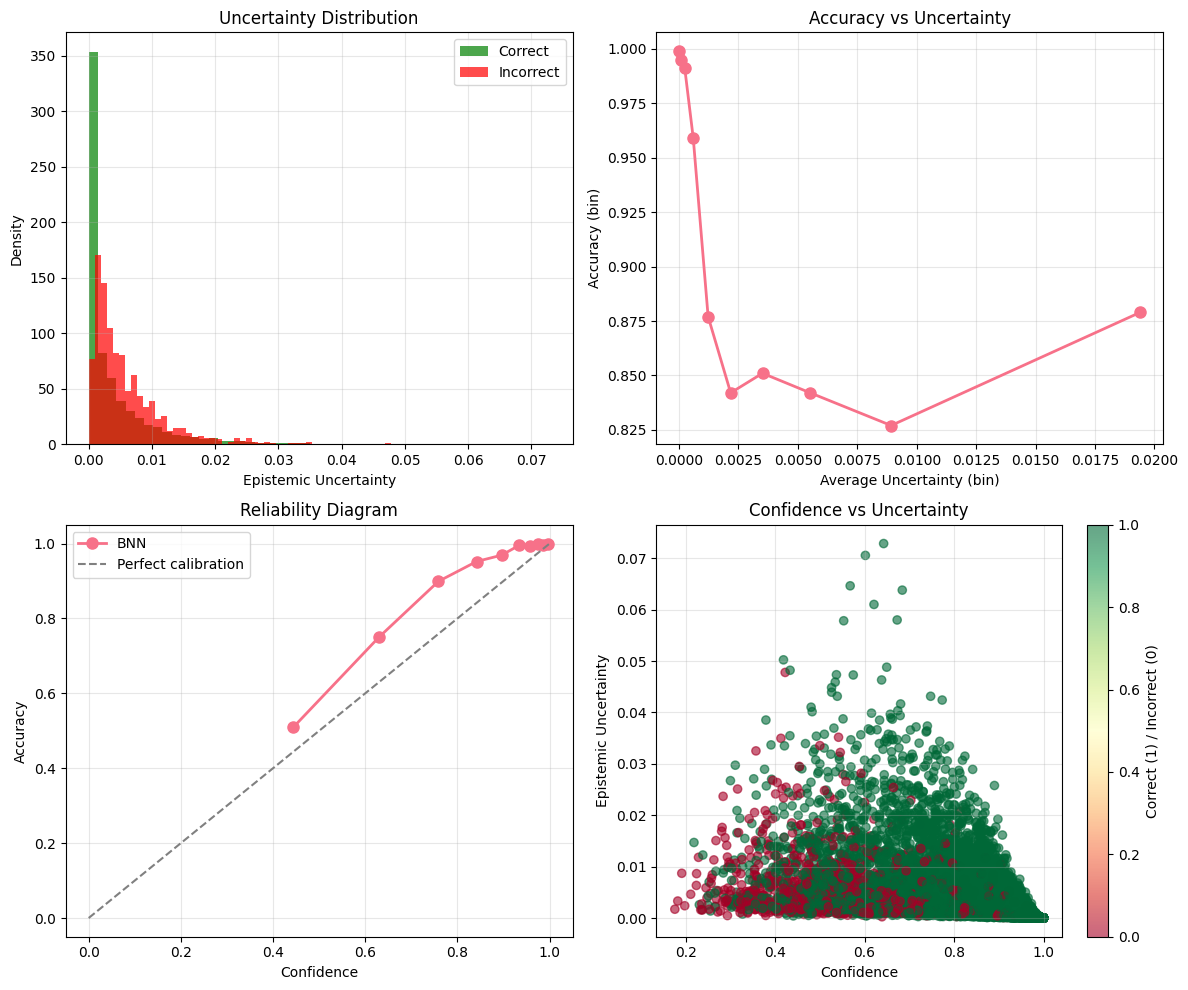

In [18]:
# Plot overview figures
_ = eval_utils.plot_uncertainty_analysis(preds, uncs, correct)


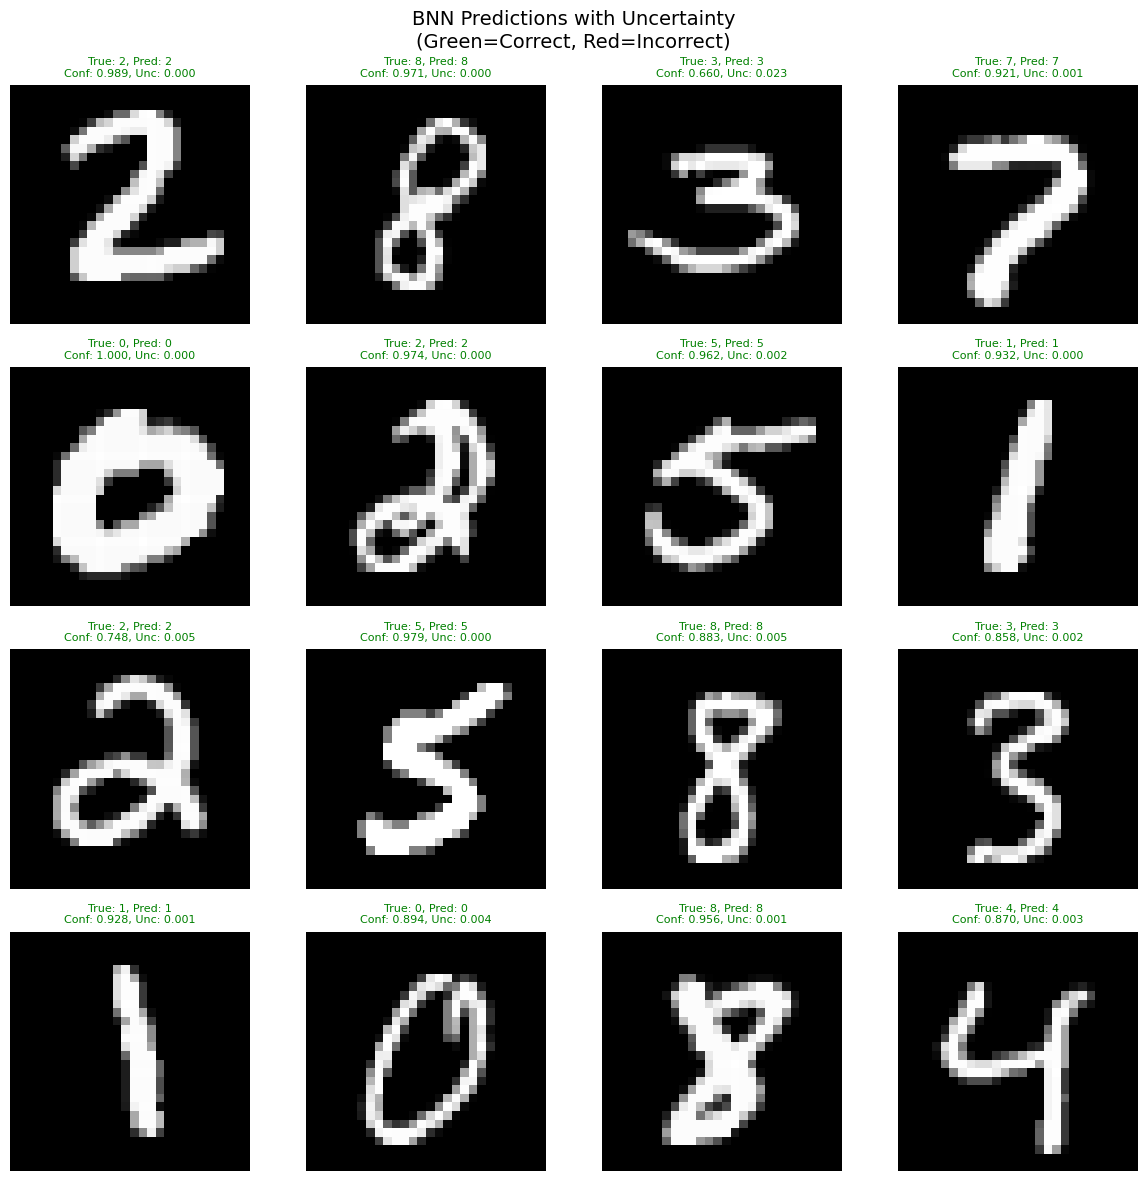

In [15]:

# Show example predictions
_ = eval_utils.plot_prediction_examples(analysis['images'], preds, uncs, labels, n_examples=16)